# playing Atari with Deep Learning

In [1]:
# choose game
game = "Pong-v0"

# generate Dataset by random play

* saving only good sequences

In [2]:
import numpy as np
import gym

env = gym.make(game)
x_data = [] # Bilder (States)
y_data = [] # Label (Aktionen)

DATASET_SIZE = 1500
saved_episodes = 0

# Datensatz generieren
the_end = False
while not the_end:
    done = False
    state = env.reset()
    episode_obs = []
    episode_acts = []
  
    while not done:
        action = env.action_space.sample()
        episode_obs.append(state)
        episode_acts.append(action)
        state, reward, done, info = env.step(action)
    
        if reward < 0:
            episode_acts = []
            episode_obs = []
        elif reward > 0:
            x_data += episode_obs
            y_data += episode_acts
            episode_obs = []
            episode_acts = []
            saved_episodes += 1
            if saved_episodes % 100 == 0:
                print(saved_episodes)
            if saved_episodes+1 > DATASET_SIZE:
                print("Dataset completed")
                the_end = True

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
Dataset completed
Dataset completed


# Preprocessing

In [3]:
x_data = np.array(x_data)
y_data = np.array(y_data)
x_data.shape, y_data.shape

((115908, 210, 160, 3), (115908,))

In [4]:
x_data[0].shape

(210, 160, 3)

### resize images to 84x84 pixels

In [5]:
import cv2
def resize(img):
    height = 84
    width = 84
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

In [6]:
resized_x_data = [resize(img) for img in x_data]
resized_x_data = np.array(resized_x_data)

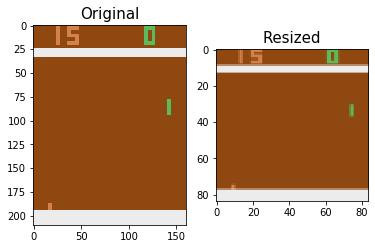

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, axs = plt.subplots(1,2)

axs[0].imshow(x_data[0, :, :, :])
axs[0].set_title("Original", fontsize="15")
axs[1].imshow(resized_x_data[0, :, :, :])
axs[1].set_title("Resized", fontsize="15")
plt.show()

### RGB to Grayscale

In [8]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    return img

In [9]:
gray_x_data = [grayscale(img) for img in resized_x_data]
gray_x_data = np.array(gray_x_data)

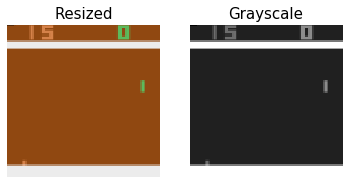

In [10]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(resized_x_data[0, :, :, :])
axs[0].set_title("Resized", fontsize="15")
axs[0].axis('off')
axs[1].imshow(gray_x_data[0, :, :, 0], cmap="gray")
axs[1].set_title("Grayscale", fontsize="15")
axs[1].axis('off')
plt.show()

### Frame Stack

In [11]:
from collections import deque
def framestack(dataset):
    data = []
    frames = deque(maxlen=4)

    # initialize first deque
    for _ in range(4):
        frames.append(dataset[0])
    framestack = np.asarray(frames, dtype=np.float32)
    framestack = np.moveaxis(framestack, 0, -1).reshape(84, 84, -1)

    # create deques from dataset
    for state in dataset:
        frames.append(state)
        framestack = np.asarray(frames, dtype=np.float32)
        framestack = np.moveaxis(framestack, 0, -1).reshape(84, 84, -1)
        data.append(framestack)

    return data

In [12]:
stack_data = framestack(gray_x_data) 
stack_data = np.array(stack_data)

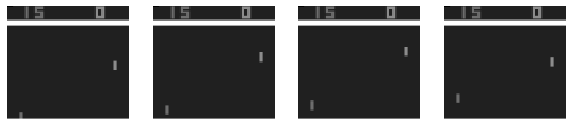

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(10,5))
axs[0].imshow(stack_data[0+4, :, :, 0], cmap="gray") # +4, because of 4 same initial frames
axs[0].axis('off')
axs[1].imshow(stack_data[1+4, :, :, 1], cmap="gray")
axs[1].axis('off')
axs[2].imshow(stack_data[2+4, :, :, 2], cmap="gray")
axs[2].axis('off')
axs[3].imshow(stack_data[3+4, :, :, 3], cmap="gray")
axs[3].axis('off')
plt.show()

### Sequenes

In [14]:
def sequences(x_data, y_data):
    x = [x_data[:4]]
    y = [y_data[3]]
    
    n = 4
    for i in range(n, x_data.shape[0]):
        x.append(x_data[4:n+4])
        y.append(y_data[i])
   
    x = np.asarray(x)
    y = np.asarray(y)
    
    return x, y

In [15]:
x_sequences, y_sequences = sequences(gray_x_data, y_data)

In [16]:
x_sequences.shape, y_sequences.shape

((115905, 4, 84, 84, 1), (115905,))

### converting labels to categorical labels

In [17]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y=y_data, num_classes=env.action_space.n)
y_seq = to_categorical(y=y_sequences, num_classes=env.action_space.n)

### shuffle data

In [18]:
# create random indices
idx = np.random.permutation(x_data.shape[0])
# x - resized grayscale input
# x_stacked - resized grayscale input in framestacks
# labels - actions in to_categorical
x, x_stacked, labels = gray_x_data[idx], stack_data[idx], y[idx]

idx_seq = np.random.permutation(x_sequences.shape[0])
x_sequences, labels_seq = x_sequences[idx_seq], y_seq[idx_seq]

# create a model


In [19]:
import tensorflow
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

def create_nn(input_shape, output_shape, lstm):
    net_input = Input(shape=input_shape) 
    
    if lstm: # Input: samples, time, rows, cols, channels
        x = ConvLSTM2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same", return_sequences=True, data_format='channels_first')(net_input)
        x = ConvLSTM2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", return_sequences=True)(x)
        x = ConvLSTM2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", return_sequences=False)(x)
    else: # Input: rows, cols, channels
        x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same", activation="relu")(net_input)
        x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", activation="relu")(x)
        x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)
    
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    net_output = Dense(output_shape, activation="softmax")(x)

    OPTIMIZER = Adam(lr=0.00005)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["categorical_accuracy"])

    return model

# Train a model on resized-grayscale input



In [20]:
x.shape[1:]

(84, 84, 1)

In [21]:
labels.shape[1]

6

In [22]:
model_1 = create_nn(x.shape[1:], labels.shape[1], False)

In [23]:
EPOCHS = 85

result_1 = model_1.fit(
    x,
    labels,
    batch_size=128,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/85


W0310 08:41:22.786848 139751205492544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


115908/115908 [==============================] - 14s 118us/sample - loss: 2.0717 - categorical_accuracy: 0.1684
Epoch 2/85
115908/115908 [==============================] - 10s 89us/sample - loss: 1.8275 - categorical_accuracy: 0.1743
Epoch 3/85
115908/115908 [==============================] - 10s 83us/sample - loss: 1.8074 - categorical_accuracy: 0.1756
Epoch 4/85
115908/115908 [==============================] - 9s 81us/sample - loss: 1.7977 - categorical_accuracy: 0.1764
Epoch 5/85
115908/115908 [==============================] - 9s 82us/sample - loss: 1.7943 - categorical_accuracy: 0.1768
Epoch 6/85
115908/115908 [==============================] - 10s 89us/sample - loss: 1.7910 - categorical_accuracy: 0.1831
Epoch 7/85
115908/115908 [==============================] - 10s 86us/sample - loss: 1.7898 - categorical_accuracy: 0.1809
Epoch 8/85
115908/115908 [==============================] - 10s 86us/sample - loss: 1.7884 - categorical_accuracy: 0.1846
Epoch 9/85
115908/115908 [==========

115908/115908 [==============================] - 10s 82us/sample - loss: 0.8797 - categorical_accuracy: 0.6700
Epoch 68/85
115908/115908 [==============================] - 10s 88us/sample - loss: 0.8677 - categorical_accuracy: 0.6745
Epoch 69/85
115908/115908 [==============================] - 10s 84us/sample - loss: 0.8527 - categorical_accuracy: 0.6816
Epoch 70/85
115908/115908 [==============================] - 10s 84us/sample - loss: 0.8423 - categorical_accuracy: 0.6847
Epoch 71/85
115908/115908 [==============================] - 10s 86us/sample - loss: 0.8299 - categorical_accuracy: 0.6894
Epoch 72/85
115908/115908 [==============================] - 9s 81us/sample - loss: 0.8192 - categorical_accuracy: 0.6925
Epoch 73/85
115908/115908 [==============================] - 10s 89us/sample - loss: 0.8075 - categorical_accuracy: 0.6970
Epoch 74/85
115908/115908 [==============================] - 10s 83us/sample - loss: 0.7969 - categorical_accuracy: 0.7034
Epoch 75/85
115908/115908 [==

In [24]:
for episode in range(5):
    done = False
    episode_reward = 0.0
    state = env.reset()
    state = resize(state)
    state = grayscale(state)
    state = np.reshape(state, (1, 84, 84, 1))
    state = state.astype("float32")
    while not done:
        action = np.argmax(model_1.predict(state))
        state, reward, done, info = env.step(action)
        state = resize(state)
        state = grayscale(state)
        state = np.reshape(state, (1, 84, 84, 1))
        state = state.astype("float32")
        episode_reward += reward
    print("Episode:", episode+1, "\tReward:", episode_reward)

Episode: 1 	Reward: -13.0
Episode: 2 	Reward: -17.0
Episode: 3 	Reward: -18.0
Episode: 4 	Reward: -12.0
Episode: 5 	Reward: -20.0


In [25]:
res1_loss = result_1.history['loss']
res1_acc = result_1.history['categorical_accuracy']

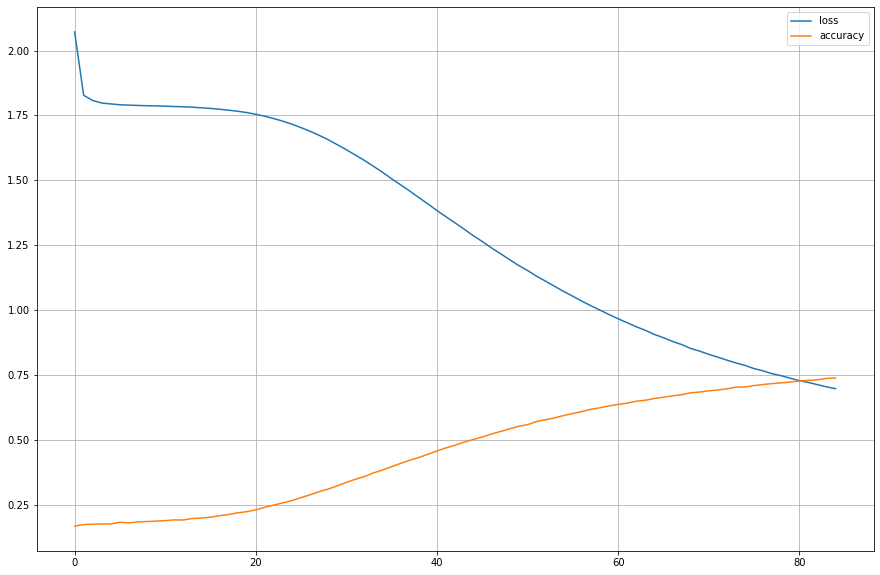

In [26]:
plt.figure(figsize=(15,10))
plt.grid(linestyle='-')
plt.plot(res1_loss, label="loss")
plt.plot(res1_acc, label="accuracy")
plt.legend()
plt.show()

In [27]:
from datetime import datetime
import os
now = datetime.now()
path = "results/" + str(now)

try:
    if not os.path.exists(path):
        os.makedirs(path)
except OSError:
    print ('Error: Creating directory. ' +  path)

In [28]:
model_1.save_weights(path + "/nn_" + str(DATASET_SIZE) + "Examples_" + str(EPOCHS) + "Epochs.h5")

In [29]:
import pandas as pd
df = pd.DataFrame(list(zip(res1_loss, res1_acc)), 
               columns =['Loss', 'Accuracy']) 
df.to_csv(path + "/nn_" + str(DATASET_SIZE) + "Examples_" + str(EPOCHS) + "Epochs.csv",mode="w", index=False)

# Train a model on resized-grayscale-framestack input



In [30]:
x_stacked.shape[1:]

(84, 84, 4)

In [31]:
labels.shape[1]

6

In [32]:
model_2 = create_nn(x_stacked.shape[1:], labels.shape[1], False)

In [33]:
EPOCHS = 85#250

result_2 = model_2.fit(
    x_stacked,
    labels,
    batch_size=128,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/85
115908/115908 [==============================] - 41s 350us/sample - loss: 2.3116 - categorical_accuracy: 0.1691
Epoch 2/85
115908/115908 [==============================] - 36s 311us/sample - loss: 1.8499 - categorical_accuracy: 0.1729
Epoch 3/85
115908/115908 [==============================] - 36s 311us/sample - loss: 1.8189 - categorical_accuracy: 0.1743
Epoch 4/85
115908/115908 [==============================] - 36s 311us/sample - loss: 1.8040 - categorical_accuracy: 0.1769
Epoch 5/85
115908/115908 [==============================] - 36s 313us/sample - loss: 1.7979 - categorical_accuracy: 0.1790
Epoch 6/85
115908/115908 [==============================] - 36s 312us/sample - loss: 1.7937 - categorical_accuracy: 0.1798
Epoch 7/85
115908/115908 [==============================] - 36s 314us/sample - loss: 1.7918 - categorical_accuracy: 0.1802
Epoch 8/85
115908/115908 [==============================] - 36s 313us/sample - loss: 1.7897 - categorical_accuracy: 0.1857
Epoch 9/85
11590

115908/115908 [==============================] - 36s 313us/sample - loss: 0.2313 - categorical_accuracy: 0.9384
Epoch 68/85
115908/115908 [==============================] - 36s 311us/sample - loss: 0.2175 - categorical_accuracy: 0.9439
Epoch 69/85
115908/115908 [==============================] - 36s 312us/sample - loss: 0.2040 - categorical_accuracy: 0.9466
Epoch 70/85
115908/115908 [==============================] - 36s 311us/sample - loss: 0.1923 - categorical_accuracy: 0.9504
Epoch 71/85
115908/115908 [==============================] - 37s 317us/sample - loss: 0.1797 - categorical_accuracy: 0.9545
Epoch 72/85
115908/115908 [==============================] - 36s 313us/sample - loss: 0.1682 - categorical_accuracy: 0.9572
Epoch 73/85
115908/115908 [==============================] - 36s 311us/sample - loss: 0.1599 - categorical_accuracy: 0.9599
Epoch 74/85
115908/115908 [==============================] - 36s 312us/sample - loss: 0.1504 - categorical_accuracy: 0.9622
Epoch 75/85
115908/1

In [34]:
for episode in range(5):
    done = False
    episode_reward = 0.0
    state = env.reset()
    state = resize(state)
    state = grayscale(state)
    state = np.reshape(state, (84, 84, 1))
    frames = deque(maxlen=4)
    # initialize deque for framestack
    for _ in range(4):
        frames.append(state)
    framestack = np.asarray(frames, dtype=np.float32)
    framestack = np.moveaxis(framestack, 0, -1).reshape(1, 84, 84, 4)#reshape(84, 84, -1)

    # playing a episode
    while not done:
        action = np.argmax(model_2.predict(framestack))
        state, reward, done, info = env.step(action)
        episode_reward += reward
        state = resize(state)
        state = grayscale(state)
        state = np.reshape(state, (84, 84, 1))
        frames.append(state)
        framestack = np.asarray(frames, dtype=np.float32)
        framestack = np.moveaxis(framestack, 0, -1).reshape(1, 84, 84, 4)
        
    print("Episode:", episode+1, "\tReward:", episode_reward)

Episode: 1 	Reward: -15.0
Episode: 2 	Reward: -17.0
Episode: 3 	Reward: -19.0
Episode: 4 	Reward: -18.0
Episode: 5 	Reward: -20.0


In [35]:
res2_loss = result_2.history['loss']
res2_acc = result_2.history['categorical_accuracy']

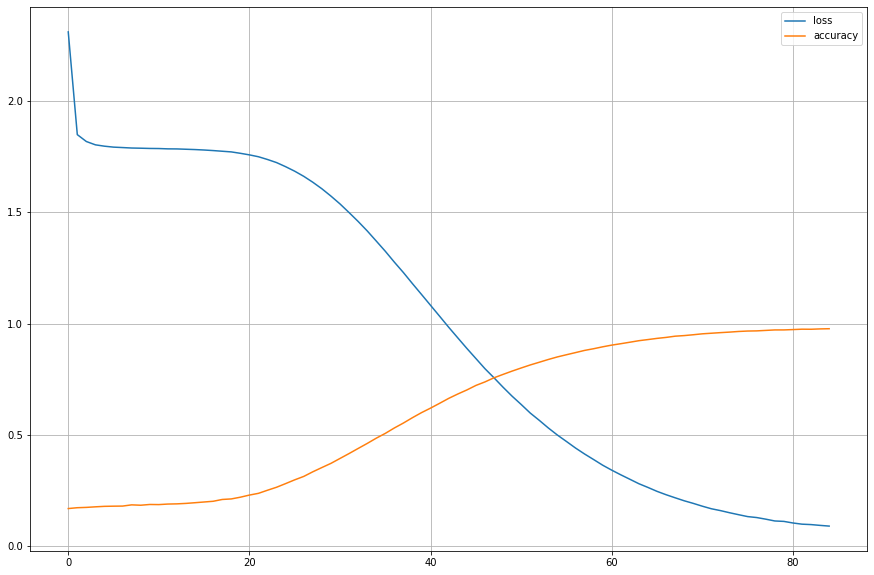

In [36]:
plt.figure(figsize=(15,10))
plt.grid(linestyle='-')
plt.plot(res2_loss, label="loss")
plt.plot(res2_acc, label="accuracy")
plt.legend()
plt.show()

In [37]:
model_2.save_weights(path + "/nn_framestack_" + str(DATASET_SIZE) + "Examples_" + str(EPOCHS) + "Epochs.h5")

In [38]:
df = pd.DataFrame(list(zip(res2_loss, res2_acc)), 
               columns =['Loss', 'Accuracy']) 
df.to_csv(path + "/nn_framestack_" + str(DATASET_SIZE) + "Examples_" + str(EPOCHS) + "Epochs.csv",mode="w", index=False)

# Train a model on image-sequences input

In [39]:
x_sequences.shape[1:]

(4, 84, 84, 1)

In [40]:
labels_seq.shape[1]

6

In [41]:
model_3 = create_nn(x_sequences.shape[1:], labels_seq.shape[1], True)

In [ ]:
EPOCHS = 85#250

result_3 = model_3.fit(
    x_sequences,
    labels_seq,
    batch_size=128,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/85


W0310 09:49:46.660785 139751205492544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1423: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115905/115905 [==============================] - 207s 2ms/sample - loss: 1.7915 - categorical_accuracy: 0.1722
Epoch 2/85
115905/115905 [==============================] - 200s 2ms/sample - loss: 1.7915 - categorical_accuracy: 0.1718
Epoch 3/85
115905/115905 [==============================] - 200s 2ms/sample - loss: 1.7915 - categorical_accuracy: 0.1723
Epoch 4/85
115905/115905 [==============================] - 200s 2ms/sample - loss: 1.7915 - categorical_accuracy: 0.1721
Epoch 5/85
115905/115905 [==============================] - 198s 2ms/sample - loss: 1.7914 - categorical_accuracy: 0.1722
Epoch 6/85
115905/115905 [==============================] - 197s 2ms/sample - loss: 1.7914 - categorical_accuracy: 0.1729
Epoch 7/85
115905/115905 [==============================] - 197s 2ms/sample - loss: 1.7914 - categorical_accuracy: 0.1729
Epoch 8/85
115905/115905 [==============================] - 198s 2ms/sample - loss: 1.7914 - categorical_accuracy: 0.1724
Epoch 9/85
115905/115905 [=========

In [ ]:
res3_loss = result_3.history['loss']
res3_acc = result_3.history['categorical_accuracy']

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(linestyle='-')
plt.plot(res3_loss, label="loss")
plt.plot(res3_acc, label="accuracy")
plt.legend()
plt.show()

In [ ]:
df = pd.DataFrame(list(zip(res3_loss, res3_acc)), 
               columns =['Loss', 'Accuracy']) 
df.to_csv(path + "/nn_seq_" + str(DATASET_SIZE) + "Examples_" + str(EPOCHS) + "Epochs.csv",mode="w", index=False)

In [ ]:
model_3.save_weights(path + "/nn_seq_" + str(DATASET_SIZE) + "Examples_" + str(EPOCHS) + "Epochs.h5")